# Introduction

This is a pretty big notebook. You'll find the lab questions all at the very end. There are 9 questions in total, including 3 challenge questions.

---

### Recap: Bayes Theorem

Bayes' theorem is a foundational concept in probability theory and statistics that describes the probability of an event, based on prior knowledge of conditions that might be related to the event. It is named after Thomas Bayes, who provided the first formulation of the principle. The theorem provides the mathematically optimal approach to estimating probabities of outcomes from data (or hypotheses from evidence, such as 'has disease' given 'positive test', or 'phoneme /k/ was spoken' given some speech input [as evidence]).

The theorem is usually stated as follows:

$$
P(Hypothesis | Evidence) = \frac{P(Evidence | Hypothesis) \times P(Hypothesis)}{P(Evidence)}
$$


Where:

- $P(Hypothesis | Evidence)$ is the **posterior probability**: the probability of the hypothesis being true, given the observed evidence.
- $P(Evidence | Hypothesis)$ is the **likelihood**: the probability of observing the evidence, given that the hypothesis is true.
- $P(Hypothesis)$ is the **prior probability**: the initial probability of the hypothesis, before observing any evidence.
- $P(Evidence)$ is the **marginal likelihood**: the total probability of observing the evidence under all possible hypotheses.

Again, the $Hypothesis$ is the outcome under consideration: has the disease, is the phoneme that was said, is the word that was said, etc.

The $Evidence$ is the data: result of a medical test, the speech input, etc.

---


### Bayesian Approach to Spoken Word Recognition

In a Bayesian framework for word recognition, we must work with probabilities conditioned on observed evidence. For our first attempt, we are going to try to follow the fairly simple logic of the Shortlist B model (Norris & McQueen, 2008). We will simulate spoken word recognition by processing one phoneme at a time. The idea is to update our beliefs (probabilities) about which word is being spoken as new phonemes are observed.

We will simplify the approach compared to Norris & McQueen in several ways. First, if you have read the Shortlist B paper carefully (which you were not asked to do!), you will know that they actually generate a 'shortlist' of words that could start at any position in the input. So if the input is 'catalog', at position 1, they essentially consider any word that starts with /k/ aligned with that position. In addition to the consider words that begin /kæ/ when they get the first vowel, they also consider words that begin with /æ/ aligned at position 2! This is very interesting, and it allows their system to parse sequences of multiple words in an elegant way. 

> *Note*: æ is the phonetic symbol for the vowel sound in cat.

However, we are simply going to make a model that does isolated word recognition only considers words aligned at position 1. However, in other respects, we will make our model like theirs as much as we can. 


#### 1. Bottom-up phoneme probabilities: frequencies, priors, etc.

An assumption on the Shortlist approach is that we will evaluate the evidence for phonemes purely on the basis of bottom-up input. This means that even at later positions, we will not evaluate the conditional probability of a phoneme (remember, phonemes are consonants and vowels, essentially) at the current evidence given both the current bottom-up evidence *and* the preceding sequence.  

So for each phoneme, we will need a way to calculate $P(Evidence|Phoneme)$ and $P(Phoneme|Evidence)$ (that is, the probability of the evidence given a specific phoneme, and the probability of that phoneme given the evidence). What is the evidence? It will be the phoneme that is the input at each position. So we could simply say that if the input is /k/, there is 100% that /k/ has occurred and 0% evidence for all other phonemes. However, we know that humans typically do not 'recognize' phonemes with 100% accuracy -- in large part because speakers' productions are not 100% unambiguous. So when the word is 'bet', listeners will be most likely to hear the first sound as /b/, but there will be some probability that they will hear it is /p/ (pet) or /g/ (get), but also very low chance that they will hear it as /s/ (set) or /f/ (fête). We will have graded confusability among phoenmes. 

We could get these from human perceptual data, like Norris and McQueen did for Dutch. But this would be a massive undertaking. In a section below, I will walk through a way to estimate these similarities in a very rough way. The results get put into a 'dataframe' (a matrix-like data object that is very much like a spreadsheet, with many records [rows] consisting of many fields [columns]) called `normalized_cosine_sim_df`. For now, just assume we are able to get reasonable similarity/confusability estimates from this dataframe. 

So when the current phoneme is /b/, we just take the B column from that dataframe, where the probability of B will be fairly high (around 0.22) while other phoneme probabilities will be quite a bit lower (max around 0.05). The idea is that when each phoneme might be present, these similarities are giving us the probability that this 'Evidence' (signal) would be present. This is possibly a point we may need to re-assess later, but we'll work with it for now. 

So at each position, we will retrieve the appropriate list of probabilities from `normalized_cosine_sim_df` and that's our evidence. However, we have to get to this (Equation 3 from Norris & McQueen, 2008) to get the posterior probability of each phoneme: 

$$
P(Phoneme_{i}|Evidence)=\frac{P(Evidence|Phoneme_{i}) \times P(Phoneme_{i})}{\sum\limits_{j=1}^{j=m}P(Evidence|Phoneme_{j}) \times P(Phoneme_{j})}
$$

where there are $m$ phonemes in the set. 

Now we need the prior probability of each phoneme. To calculate this, we add up how often every phoneme occurs in lexicon or corpus, and then divide the count for each phoneme by the sum of counts for all phonemes. These will be stored later in a data frame called `phoneme_count_df`. Then we just multiply the `normalized_cosine_sim_df` by the `phon_prob` field in the `phoneme_count_df` dataframe to do the step of multipying $P(Evidence|Phoneme_{i}) \times P(Phoneme_{i})$. 

We cacluate the numerator for each phoneme and sum up all the results (which is equivalent to the denominator). Then we divide each value by that sum.  

#### 2. Prior Probability (Word Frequency)

Before any phonemes are observed, our belief about which word is likely to be spoken would be based on the frequency with which each word occurs in the language. This is our *prior distribution*,  $ P(W) $, where $ W $ is the set of all possible words. In the simplest case, we convert freqencies to probabilities by normalizing them -- we divide each word's frequency by the sum of all words' frequencies.

#### 3. Likelihood (words)

As each new phoneme is observed, we want to update our estimate of how likely each word is to be the current word (that is coming in phoneme-by-phoneme). So we take the $PhonemeString$ that has emerged so far as the Evidence, and then need to calculate $P(Word_{i}|Evidence)$ for each word $i$ (that is, we need to calculate the probability of word $i$ given the input thus far). We can do this using Equation 4 from Norris & McQueen. 

$$
Likelihood(Word_{i}) = P(Evidence|Word_{i})=P(PhonemeString_{i})=\prod\limits_{j=1}^{l}P(Phoneme_{j}|Evidence)
$$

So this says that we will take the product of all the $P(Phoneme|Evidence)$ for all $l$ phonemes. So if the input word is 'cat', the phonemes are $K, AE, T$, and we would calculate $P(K|K) \times P(AE|AE) \times P(T|T)$ (e.g., where $P(T|T)$ the value we get for $T$ when the input is $T$ from `nomalized_cosine_sim_df` $\times$ the `phon_prob` value from `phoneme_count_df`. (Remember, it may seem like p(K|K) [probability of K given K as input] should be 1.0, but in fact, it will be much lower than that in our similarity estimates -- only 0.2; we will discuss this in class.)

#### 4. Posterior Probability (words)

Then to get the posterior probability for each word at the current position, we use Equation 5 from Norris & McQueen.

$$
P(Word_{i}|Evidence)=\frac{P(Evidence|Word_{i}) \times P(Word_{i})}
{\sum\limits_{j=1}^{j=n}P(Evidence|Word_{j}) \times P(Word_{j})}
$$

which we can calculate by using $PhonemeString$ values:

$$
Posterior = P(Word_{i}|Evidence)=\frac{P(PhonemeString_{i}) \times P(Word_{i})}
{\sum\limits_{j=1}^{j=n}P(PhonemeString_{j}) \times P(Word_{j})}
$$

So we will do this at each phoneme position. 

#### 5. Normalization

For each step, we always have to do a final normalization so that any quantities that we want to be probabilities sum to 1.0.

---

Let's try to implement this model! 

### Step 1: Import the lexicon

The first thing we need is a lexicon that will have the list of words we want to consider, and their *prior probabilities*. Prior probability for words is usually expressed as frequency [occurrences] per million words. To calculate this, we take a big *corpus* of text or speech. For example, we could take 10 years worth of the text of the *New York Times*, everything that has ever been posted on Twitter, or we could use ever-growing databases that compile subtitles from speech transcribed for movies, shows, etc. 

We are going to use a lexicon called *lemmalex* that uses a variety of sources, but mainly subtitle databases. This is from a tool for the R statistical programming language that my lab released called *LexFindR* (Li, Z., Crinnion, A. M., & Magnuson, J. S. (2021). LexFindR: A fast, simple, and extensible R package for finding similar words in a lexicon. *Behavior Research Methods*. https://doi.org/10.3758/s13428-021-01667-6). 

Let's read it into a dataframe called `lexicon_df`. We will also create a log frequency column. Then we can look at the first 5 rows by calling `lexicon_df.head()`:

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np

# Function to read in the lexicon file
def read_lexicon_file(filepath):
    lexicon_df = pd.read_csv(filepath)
    return lexicon_df

# Read the lexicon file
lexicon_df = read_lexicon_file('./lemmalex.csv')

# Drop any NaN values in the 'Pronunciation' column
lexicon_df = lexicon_df.dropna(subset=['Pronunciation'])

# add log frequency column
lexicon_df['lfrq'] = np.log(lexicon_df['Frequency'] + 1)
lexicon_df.head()


,Item,Frequency,Pronunciation,lfrq
0,a,20415.27,AH,9.924087
1,abandon,8.10,AH B AE N D IH N,2.208274
2,abandonment,0.96,AH B AE N D AH N M AH N T,0.672944
3,abate,0.10,AH B EY T,0.095310
4,abbey,3.18,AE B IY,1.430311


---

Here are simple ways to get the length (number of rows) in the dataframe and also to summarize its numerical columns: 

In [2]:
# this will show that there are 17,750 words in the lexicon
len(lexicon_df), lexicon_df.describe()

(17750,
           Frequency          lfrq
 count  17750.000000  17750.000000
 mean      43.262201      1.222613
 std      651.204163      1.398385
 min        0.020000      0.019803
 25%        0.250000      0.223144
 50%        1.020000      0.703098
 75%        4.760000      1.750937
 max    41857.120000     10.642041)

---

### Look at frequency using histograms

Wow, those frequency ranges are huge -- from 0.02 occurrence per million words to 41,857! 

Let's make a function that will plot histograms and then a 'cumulative sort plot'. The histogram plots the frequency of different values. The sort plot just sorts the values and plots them in sequence. We will see that there are a very small number of very high frequency items (like the words 'the' or 'a'). 

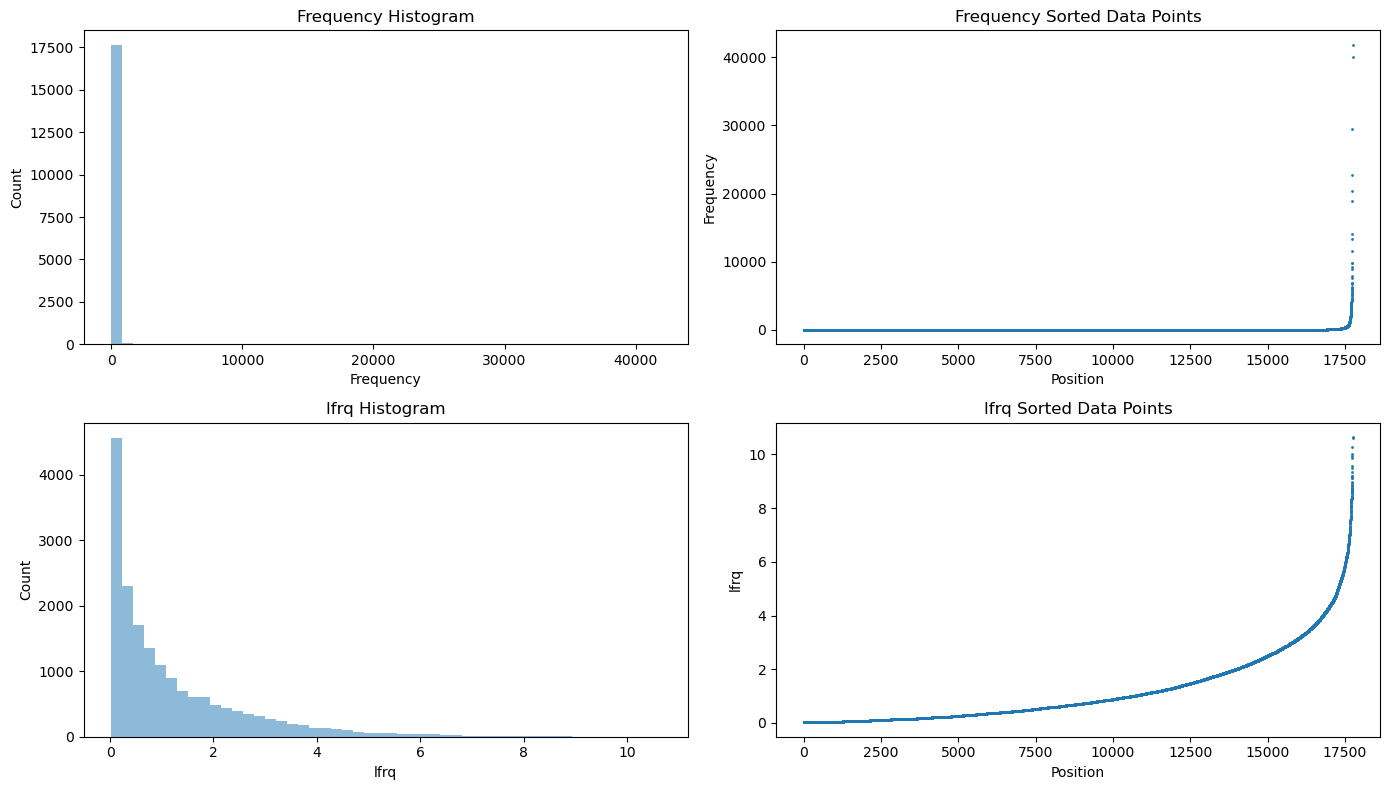

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


def plot_histograms(df, columns, pointsize=1, alphaval = 0.5, bins=50):
    """
    Plots histograms for the specified columns of the given DataFrame.
    Adds a subplot below each histogram to show the individual data points.
    
    Parameters:
        df (DataFrame): The DataFrame containing the specified columns.
        columns (list): List of column names to plot.
    """
    # Calculate the number of rows needed for the subplots
    n_rows = len(columns)
    
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows), gridspec_kw={'width_ratios': [4, 4]})
    
    # If there's only one row, axs is a 1D array and we need to reshape it
    if n_rows == 1:
        axs = axs.reshape(1, -1)
    
    # Flatten the axs array for easy iteration
    axs = axs.flatten()
    
    # Plot histograms and individual data points
    for idx, col in enumerate(columns):
        # Plot histogram
        axs[2 * idx].hist(df[col], bins=bins, alpha=alphaval)
        axs[2 * idx].set_title(f'{col} Histogram')
        axs[2 * idx].set_xlabel(col)
        axs[2 * idx].set_ylabel('Count')
        # Apply log scale to raw frequency ('Frequency') histogram
        # if col == 'Frequency':
        #     axs[2 * idx].set_xscale('log')
        #     axs[2 * idx].set_yscale('log')
        
        # Plot individual data points sorted by value
        sorted_data = np.sort(df[col].values)
        axs[2 * idx + 1].plot(sorted_data, marker='o', linestyle='', markersize = pointsize)
        axs[2 * idx + 1].set_title(f'{col} Sorted Data Points')
        axs[2 * idx + 1].set_xlabel('Position')
        axs[2 * idx + 1].set_ylabel(col)
        
        # Apply log scale to raw frequency ('Frequency') histogram
        # if col == 'Frequency':
        #     axs[2 * idx + 1].set_xscale('log')
        #     axs[2 * idx + 1].set_yscale('log')

    # Hide any extra subplots
    for idx in range(2 * len(columns), len(axs)):
        axs[idx].axis('off')

    
    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
plot_histograms(lexicon_df, ['Frequency', 'lfrq'])


### Trimming based on frequency

For reasons we can discuss in class, having small numbers of items with very high frequency is problematic. Let's just cut items with log frequency more than 3 standard deviations above the mean. (For those of you who care about these details, Berger & Kiefer [2021] compared various methods for trimming outlying values and found that a simple 3SD threshold is a minimally biased approach; they are concerned with reaction time data, but this is a fine way to proceed for our purposes... if this were a research project we intended to publish, we would have to delve a bit deeper and really understand the characteristics of the items we are trimming).


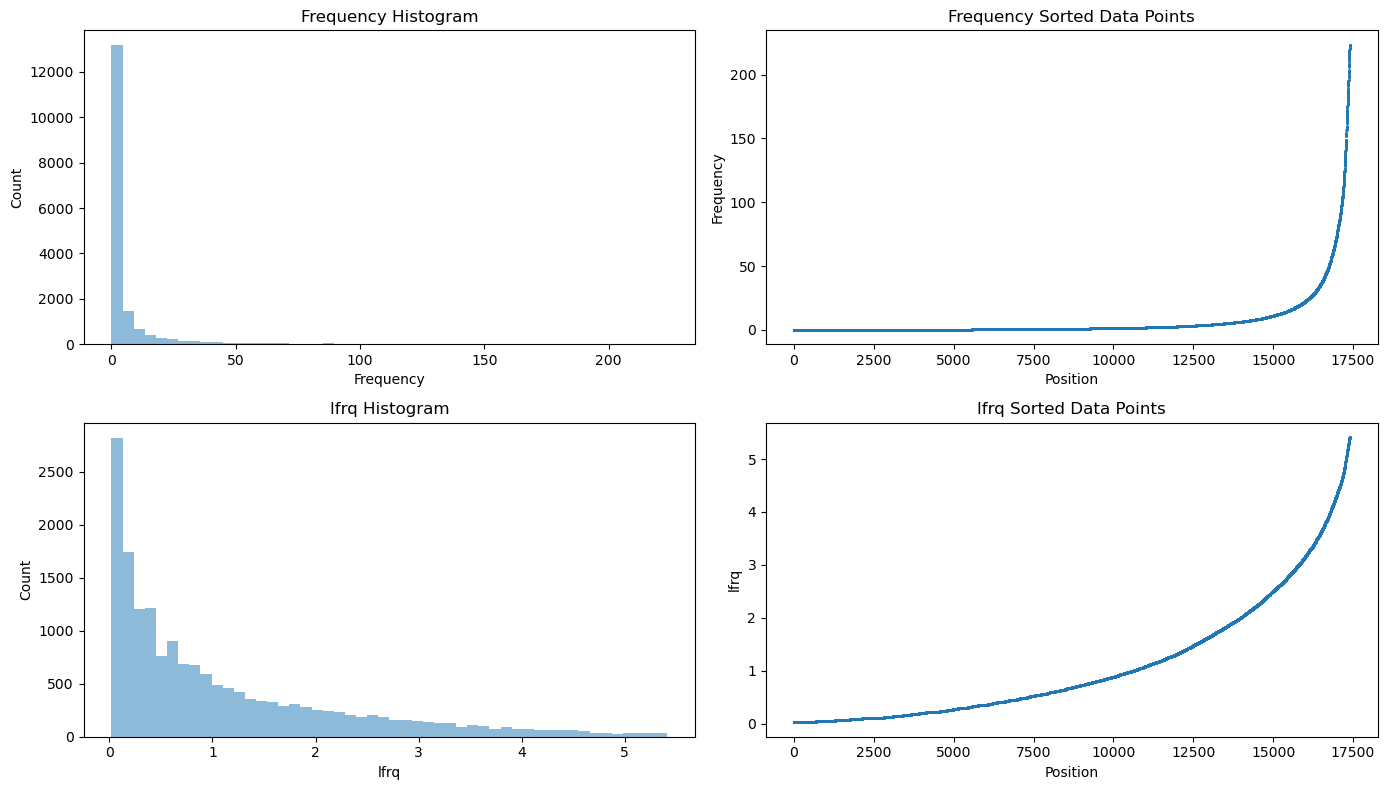

In [4]:
# Calculate mean and standard deviation of 'lfrq'
mean_lfrq = lexicon_df['lfrq'].mean()
std_lfrq = lexicon_df['lfrq'].std()

# Define the boundaries for acceptable 'lfrq' values
lower_bound = mean_lfrq - 3 * std_lfrq
upper_bound = mean_lfrq + 3 * std_lfrq

# Remove records where 'lfrq' is more than 3 standard deviations from the mean
filtered_lexicon_df = lexicon_df[(lexicon_df['lfrq'] >= lower_bound) & (lexicon_df['lfrq'] <= upper_bound)]

# replot histograms
plot_histograms(filtered_lexicon_df, ['Frequency', 'lfrq'])


The **trimmed data** seems better. We have a smaller range, and fewer points way out at high values. Next code cells describe and then just take the filtered lexicon as our default lexicon.

In [5]:
# much better; let's redescribe
filtered_lexicon_df.describe()

,Frequency,lfrq
count,17397.000000,17397.000000
mean,7.590574,1.112872
std,21.898453,1.168418
min,0.020000,0.019803
25%,0.240000,0.215111
50%,0.960000,0.672944
75%,4.240000,1.656321
max,223.550000,5.414098


In [6]:
# let's just replace lexicon_df with the filtered one
lexicon_df = filtered_lexicon_df

---

### An aside: phonemes

Again, phonemes are roughly the consonants and vowels of a language. Note that there is not a 1-to-1 mapping between phonemes and letters in English. We can get a /k/ sound from the letters C, K, QU, for example. The letter A can link to sounds like *ay*, *eh*, *uh*, *ah*, *ae* [as in cat], etc. In North American English dialects, we typically have 39-40 phonemes that we have to represent using 26 letters. 

Linguists use the International Phonetic Alphabet to transcribe sounds across languages. The lexicon file we are using uses a symbol system often used in natural language processing computing called *Arpabet*. Here's how to map phonemes to IPA and to actual sounds using examples. This data for this table comes from the website of a speech recognition company called Soapbox.

| Arpabet (SoapBox) | IPA | Example   |
|-------------------|-----|-----------|
| AA                | ɑ   | balm, bot |
| AE                | æ   | bat       |
| AH                | ʌ   | butt      |
| AO                | ɔ   | cot       |
| AW                | aʊ  | bout      |
| AY                | aɪ  | bite      |
| EH                | ɛ   | bet       |
| ER                | ɝ   | bird      |
| EY                | eɪ  | bait      |
| IH                | ɪ   | bit       |
| IY                | i   | beat      |
| OW                | oʊ  | boat      |
| OY                | ɔɪ  | boy       |
| UH                | ʊ   | book      |
| UW                | u   | boot      |
| B                 | b   | buy       |
| CH                | tʃ  | china     |
| D                 | d   | die       |
| DH                | ð   | thy, bathe|
| F                 | f   | fight     |
| G                 | g   | guy       |
| HH                | h   | high      |
| JH                | dʒ  | jump      |
| K                 | k   | kite      |
| L                 | l   | lie       |
| M                 | m   | my        |
| N                 | n   | night     |
| NG                | ŋ   | sing      |
| P                 | p   | pie       |
| R                 | ɹ   | rye       |
| S                 | s   | sigh      |
| SH                | ʃ   | shy       |
| T                 | t   | tie       |
| TH                | θ   | think     |
| V                 | v   | vie       |
| W                 | w   | wise      |
| Y                 | j   | yacht, yet|
| Z                 | z   | zoo       |
| ZH                | ʒ   | pleasure  |


---

### Phoneme similarity


We are going to do simulations by presenting one phoneme at a time. We could use 'localist' or 'one-hot' representations, where each phoneme has a discrete value and no similarity to other phonemes (so when the input is /k/, the evidence for /k/ would be 100% and evidence for all other phonemes would be 0%). However, we know from a century of research that humans perceive some phonemes (e.g., 'b' and 'p') as more similar than others (e.g., 'b' and 'a' are not similar). So we want to include this in our simulation. If the word is 'bat', the phoneme /b/ should give us high evidence that /b/ has occurred, but also moderate evidence that /p/ may have occurred, and very low evidence that /o/ occurred (because /b/ is quite similar to /p/ but quite different from /o/, phonetically). 

There are various ways to estimate similarity. For example, we can present phonemes in noise to listeners and ask them to transcribe what they hear. Then we can calculate 'confusability' or similarity as how often, for example, people answered 'p' when the actual input was 'b'. 

There are a *lot* of potential sources for such 'confusion' data, but it is not obvious how to use it. For example, Luce (1986) argued in his dissertation that his confusion data could not generalize beyond the specific conditions under which it was collected -- it applied for a particular level of noise, etc. 

I have colleagues in Spain who are working on some new, very principled approaches. While we wait for them to supply their similarity matrices, let's figure out a way to do our own.

### Phonetic similarity

We could use featural definitions of phonemes. For example, /p/ and /b/ are both bilabial stops. The only difference is that /b/ is 'voiced' while /p/ is 'voiceless'. We could compare phonemes on their featural similarity. We might do this later... However, it would be nice to have a method that does not depend on us knowing the featural definitions (in case we want to extend to another language where that information is not readily available). 

### Context similarity

It turns out that we can learn a lot about some element in the world or in a system (phoneme, word, object) by the company it keeps. Let's just go through the lexicon and count how many times any phoneme pair co-occurs adjacently. So for example, the word 'cat' has the phonemes /k/, /æ/, and /t/. So we could increment the count for /kæ/ and /æt/, the two pairs of phonemes that occur. To tabulate this, we'll make a phoneme-by-phoneme matrix. So for cat, we would increment the counts for {k,æ}, {æ, k}, {æ, t}, and {t, æ}. However, we should also adjust this for word frequency. The word cat occurs fairly often, so we would want to boost these counts a bit more than the counts for the same pairs from the word catalytic. We will use word frequency to do this. 

What we will end up with is a phoneme-by-phoneme matrix that counts how often each phoneme occurs with every other phoneme. At the end of the code cell, we display a bit of the matrix, and also the calculated prior probability for each phoneme.

In [7]:

# Extract unique phonemes
unique_phonemes = set()
for pronunciation in lexicon_df['Pronunciation']:
    phonemes = pronunciation.split()
    unique_phonemes.update(phonemes)
sorted_unique_phonemes = sorted(list(unique_phonemes))
num_phonemes = len(sorted_unique_phonemes)
phoneme_to_index = {phoneme: index for index, phoneme in enumerate(sorted_unique_phonemes)}

# Create a weighted matrix for phoneme pairs
weighted_phoneme_matrix_dict = defaultdict(float)
# create dictionary for frequency-weighted counts of each phoneme
phoneme_count_dict = defaultdict(float)


# Now let's fill the matrix
fweight = 1.0 # how much to use frequency; when set to 1, just use full value
for _, row in lexicon_df.iterrows():
    pronunciation, lfrq = row['Pronunciation'], row['lfrq']
    phonemes = pronunciation.split()
    
    # Update the frequency-weighted count for each individual phoneme
    for phoneme in phonemes:
        phoneme_count_dict[phoneme] += (lfrq * fweight)
 
    for i in range(len(phonemes) - 1):
        first_phoneme, second_phoneme = phonemes[i], phonemes[i + 1]
        weighted_phoneme_matrix_dict[(first_phoneme, second_phoneme)] += (lfrq * fweight)
        weighted_phoneme_matrix_dict[(second_phoneme, first_phoneme)] += (lfrq * fweight)


# Initialize the weighted matrix
weighted_phoneme_matrix = np.zeros((num_phonemes, num_phonemes), dtype=float)
for (first, second), count in weighted_phoneme_matrix_dict.items():
    i, j = phoneme_to_index[first], phoneme_to_index[second]
    weighted_phoneme_matrix[i, j] = count

# Convert the matrix to a DataFrame for better readability
weighted_phoneme_matrix_df = pd.DataFrame(weighted_phoneme_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Convert the phoneme_count_dict to a DataFrame for better readability
phoneme_count_df = pd.DataFrame(list(phoneme_count_dict.items()), columns=['Phoneme', 'FrequencyWeightedCount']).sort_values(by='FrequencyWeightedCount', ascending=False)

# Calculate the sum of all FrequencyWeightedCount values
total_count = phoneme_count_df['FrequencyWeightedCount'].sum()

# Add a new column for normalized probabilities
phoneme_count_df['phon_prob'] = phoneme_count_df['FrequencyWeightedCount'] / total_count

# Create a simpler dictionary that just pairs phonemes with their normalized probabilities (phon_prob)
phoneme_prob_dict = dict(zip(phoneme_count_df['Phoneme'], phoneme_count_df['phon_prob']))
phoneme_prob_dict

# Display a portion of the weighted matrix and phoneme count matrix for review
weighted_phoneme_matrix_df.iloc[:10, :5], phoneme_prob_dict#,phoneme_count_df.iloc[:100, :10]


(            AA          AE           AH         AO         AW
 AA    0.000000    0.000000     0.000000   0.000000   0.000000
 AE    0.000000    0.000000     0.000000   0.000000   0.000000
 AH    0.000000    0.000000     1.280758   1.350667  39.343166
 AO    0.000000    0.000000     1.350667   0.000000   0.000000
 AW    0.000000    0.000000    39.343166   0.000000   0.000000
 AY    7.207485    5.742495   102.973433   2.414126   0.000000
 B   185.558680  283.949295  1000.629454  54.270354  24.262590
 CH   40.617086  108.511521   210.936280   5.700518  10.245048
 D   134.052686  186.728707   844.436416  55.920047  56.054154
 DH    8.222988   14.214397    90.675537   0.000000   3.154017,
 {'AH': 0.1041717568844594,
  'R': 0.08762797978723763,
  'IH': 0.0799592708972376,
  'T': 0.06813767731764012,
  'N': 0.06763029365957593,
  'S': 0.06098663594854901,
  'L': 0.05478876040112506,
  'K': 0.04727856415076621,
  'D': 0.03389393117466113,
  'IY': 0.033529270909775345,
  'P': 0.033084815530742

In [8]:
probability_for_AH = phoneme_prob_dict.get("AH", "Phoneme not found")
probability_for_AH

0.1041717568844594

---

### Converting counts to similarities

Once we have the matrix, now we can take the rows or columns as 'representations' of each phoneme, in terms of how often the phoneme co-occurs with other phonemes. To get pairwise similarity, we could compare the Euclidean distance of the vectors. Another approach is to use *cosine* similarity. 

## Cosine Similarity

Cosine similarity is a metric used to determine the cosine of the angle between two non-zero vectors in an inner product space. It is used to measure how similar two vectors are. The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1]. However, if we allow negative space, it's still bounded as [-1,1], where 1 = same direction, -1 = opposite direction, and 0 means orthogonal (perpendicular).

The formula to find the cosine similarity between two vectors $ A $ and $ B $ is given by:

$$
\text{Cosine Similarity} = \cos(\theta) = \frac{{A \cdot B}}{{\|A\| \times \|B\|}}
$$

Where $ A \cdot B $ is the dot product of the vectors $ A $ and $ B $, and $ \|A\| $ and $ \|B\| $ are the magnitudes (or Euclidean norms) of vectors $ A $ and $ B $ respectively.

### Properties of Cosine Similarity

1. **Directions rather than length/distance**: Cosine similarity focuses only on the orientation of vectors, not their magnitude. 

2. **Efficient to Compute**: For sparse vectors, cosine similarity is generally more efficient to compute than Euclidean distance.

3. **Bounded Range**: Cosine similarity ranges from -1 to 1, making it easy to interpret.

### Example

Consider two vectors $ A = [1, 2] $ and $ B = [2, 3] $.

1. **Dot Product $ A \cdot B $**:
$$
A \cdot B = 1 \times 2 + 2 \times 3 = 2 + 6 = 8
$$

2. **Magnitude of A $ \|A\| $**:
$$
\|A\| = \sqrt{1^2 + 2^2} = \sqrt{1 + 4} = \sqrt{5}
$$

3. **Magnitude of B $ \|B\| $**:
$$
\|B\| = \sqrt{2^2 + 3^2} = \sqrt{4 + 9} = \sqrt{13}
$$

4. **Cosine Similarity**:
$$
\text{Cosine Similarity} = \frac{8}{\sqrt{5} \times \sqrt{13}} \approx 0.9839
$$

The value is close to 1, indicating that the vectors are very similar in orientation.

To make it very clear that cosines are about *directions*, let's redefine $B$ as $[2, 4]$ and recalculate. To calculate the cosine similarity between vectors $ A = [1, 2] $ and $ B = [2, 4] $, the formula is:

$$
\text{Cosine Similarity} = \frac{A \cdot B}{||A|| \times ||B||}
$$

1. **Dot Product $ A \cdot B $**: $ (1 \times 2) + (2 \times 4) = 2 + 8 = 10 $
2. **Euclidean Norm $ ||A|| $**: $ \sqrt{1^2 + 2^2} = \sqrt{1 + 4} = \sqrt{5} $
3. **Euclidean Norm $ ||B|| $**: $ \sqrt{2^2 + 4^2} = \sqrt{4 + 16} = \sqrt{20} $
4. **Cosine Similarity**: $ \frac{10}{\sqrt{5} \times \sqrt{20}} = \frac{10}{\sqrt{100}} = \frac{10}{10} = 1 $

The cosine similarity is 1, indicating that the vectors are identical in orientation (even though B extends twice as far in both dimensions). This will be true when the vectors are *scalars* of each other (multiples; i.e., there is a single value you can multiply vector $A$ by that will give you vector $B$). So $A = [1, 2]$ and $B = [4, 8]$ are scalars since $A \times 8 = B$. The cosine of $A = [1, 2]$ and $B = [.5, 1]$ will also be 1 because $A \times 0.5 = B$.When cosine is 1, this means the vectors *point* in the same direction, even though they may have different lengths. When vectors have a cosine of -1 (e.g., $A = [1, 2]$ and $B = [-4, -8]$) they point in opposite directions.

---

***Note.*** The operation in linear algebra that gives the magnitude of a vector is known as the vector norm. Specifically, the Euclidean norm (or $ L_2 $ norm) is commonly used to calculate the magnitude of a vector $ \mathbf{v} $ in Euclidean space. The formula for the Euclidean norm of a vector $ \mathbf{v} = [v_1, v_2, \ldots, v_n] $ is:

$$
\|\mathbf{v}\| = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$

The Euclidean norm provides a measure of the "length" of the vector from the origin to the point represented by the vector in $ n $-dimensional space.

---

So: let's get cosine similarities using a the sci-kit-learn library.

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity between each pair of phoneme vectors
cosine_sim_matrix = cosine_similarity(weighted_phoneme_matrix)

# Convert the similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the cosine similarity matrix
cosine_sim_df.iloc[:10, :10]


,AA,AE,AH,AO,AW,AY,B,CH,D,DH
AA,1.000000,0.966031,0.931129,0.848900,0.757327,0.785100,0.258615,0.311287,0.359275,0.116166
AE,0.966031,1.000000,0.948020,0.808589,0.845911,0.856638,0.242135,0.328735,0.371903,0.096337
AH,0.931129,0.948020,1.000000,0.892759,0.798543,0.891911,0.295744,0.334902,0.415630,0.130527
AO,0.848900,0.808589,0.892759,1.000000,0.566249,0.766836,0.306023,0.243556,0.328706,0.143260
AW,0.757327,0.845911,0.798543,0.566249,1.000000,0.814663,0.268305,0.461216,0.487079,0.183749
AY,0.785100,0.856638,0.891911,0.766836,0.814663,1.000000,0.358534,0.364591,0.413384,0.206859
B,0.258615,0.242135,0.295744,0.306023,0.268305,0.358534,1.000000,0.820980,0.765612,0.933101
CH,0.311287,0.328735,0.334902,0.243556,0.461216,0.364591,0.820980,1.000000,0.950619,0.757804
D,0.359275,0.371903,0.415630,0.328706,0.487079,0.413384,0.765612,0.950619,1.000000,0.692227
DH,0.116166,0.096337,0.130527,0.143260,0.183749,0.206859,0.933101,0.757804,0.692227,1.000000


We can see that self-similarity (cosine) is 1.0 for all phonemes. We can also see that some pairs have extremely high cosines -- e.g., $[/AA/, /AE/]= 0.966031$. This is probably too high. Let's downweight the non-identity similarities by dividing them by a constant. 

**Note**: This is a very consequential decision (dividing by 5). We may want to try smaller or larger values...

In [10]:
# Adjust the diagonal entries from 1.0 to 0.9
#np.fill_diagonal(cosine_sim_matrix, 0.9)

# Reduce the off-diagonal entries -- divide by 5 for now
off_diagonal_indices = np.where(~np.eye(cosine_sim_matrix.shape[0], dtype=bool))
adjusted_cosine_sim_matrix = cosine_sim_matrix.copy()
adjusted_cosine_sim_matrix[off_diagonal_indices] /= 5.0

# Convert the adjusted similarity matrix to a DataFrame for better readability
adjusted_cosine_sim_df = pd.DataFrame(adjusted_cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the adjusted cosine similarity matrix
adjusted_cosine_sim_df.iloc[:10, :10]


,AA,AE,AH,AO,AW,AY,B,CH,D,DH
AA,1.000000,0.193206,0.186226,0.169780,0.151465,0.157020,0.051723,0.062257,0.071855,0.023233
AE,0.193206,1.000000,0.189604,0.161718,0.169182,0.171328,0.048427,0.065747,0.074381,0.019267
AH,0.186226,0.189604,1.000000,0.178552,0.159709,0.178382,0.059149,0.066980,0.083126,0.026105
AO,0.169780,0.161718,0.178552,1.000000,0.113250,0.153367,0.061205,0.048711,0.065741,0.028652
AW,0.151465,0.169182,0.159709,0.113250,1.000000,0.162933,0.053661,0.092243,0.097416,0.036750
AY,0.157020,0.171328,0.178382,0.153367,0.162933,1.000000,0.071707,0.072918,0.082677,0.041372
B,0.051723,0.048427,0.059149,0.061205,0.053661,0.071707,1.000000,0.164196,0.153122,0.186620
CH,0.062257,0.065747,0.066980,0.048711,0.092243,0.072918,0.164196,1.000000,0.190124,0.151561
D,0.071855,0.074381,0.083126,0.065741,0.097416,0.082677,0.153122,0.190124,1.000000,0.138445
DH,0.023233,0.019267,0.026105,0.028652,0.036750,0.041372,0.186620,0.151561,0.138445,1.000000


This looks better. Let's normalize the values though to treat them like probabilities. 

In [11]:
# Normalize the rows of the adjusted cosine similarity matrix so they sum to 1
row_sums = adjusted_cosine_sim_matrix.sum(axis=1)
normalized_cosine_sim_matrix = adjusted_cosine_sim_matrix / row_sums[:, np.newaxis]

# Convert the normalized similarity matrix to a DataFrame for better readability
normalized_cosine_sim_df = pd.DataFrame(normalized_cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the normalized cosine similarity matrix
normalized_cosine_sim_df.iloc[:10, :10]

,AA,AE,AH,AO,AW,AY,B,CH,D,DH
AA,0.231184,0.044666,0.043052,0.039250,0.035016,0.036300,0.011958,0.014393,0.016612,0.005371
AE,0.043542,0.225367,0.042730,0.036446,0.038128,0.038612,0.010914,0.014817,0.016763,0.004342
AH,0.041180,0.041927,0.221132,0.039483,0.035317,0.039446,0.013080,0.014811,0.018382,0.005773
AO,0.041679,0.039700,0.043833,0.245491,0.027802,0.037650,0.015025,0.011958,0.016139,0.007034
AW,0.034274,0.038283,0.036140,0.025627,0.226284,0.036869,0.012143,0.020873,0.022044,0.008316
AY,0.032920,0.035920,0.037399,0.032154,0.034160,0.209655,0.015034,0.015288,0.017334,0.008674
B,0.009705,0.009087,0.011098,0.011484,0.010069,0.013455,0.187634,0.030809,0.028731,0.035016
CH,0.011055,0.011675,0.011894,0.008650,0.016379,0.012948,0.029156,0.177568,0.033760,0.026912
D,0.012692,0.013139,0.014683,0.011613,0.017208,0.014604,0.027048,0.033583,0.176640,0.024455
DH,0.004986,0.004135,0.005602,0.006149,0.007886,0.008878,0.040048,0.032524,0.029710,0.214597


*When we divide non-identity values by 2, the normalized values wind up being around 0.1 for identity and 0.05 for highly similar items. These may be too similar, so I've instead divided by 5. This makes the identity values around 0.22 and high sim items 0.04. Might not be perfect, but let's try this. *

---

### Visualizing similarity

A simple and effective way to visualize similarity when we have a matrix is to use a *heatmap*, where color indicates value. 

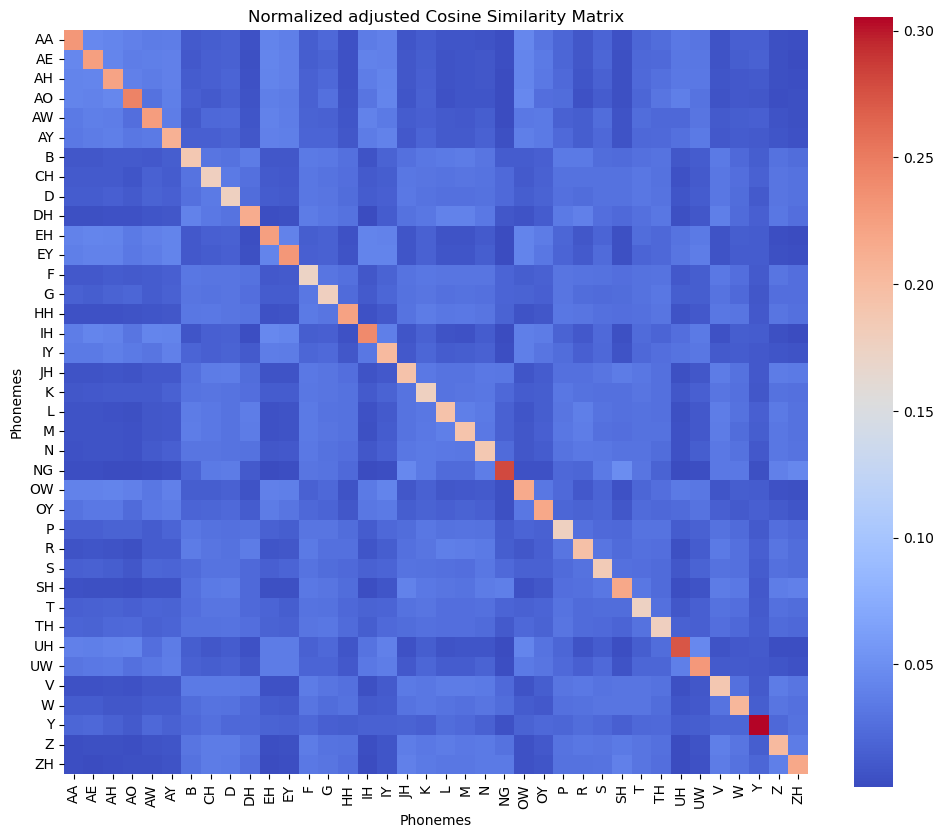

In [12]:
# let's visualize it

import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(normalized_cosine_sim_df, annot=False, cmap="coolwarm", cbar=True, square=True)

# Add labels and title
plt.title("Normalized adjusted Cosine Similarity Matrix")
plt.xlabel("Phonemes")
plt.ylabel("Phonemes")

# Adjust the font size of the tick labels
# plt.xticks(fontsize=6)
# plt.yticks(fontsize=8)

# Show the plot
plt.show()


So we can definitely see structure here. But phonemes are sorted alphabetically. Could we resort in some way to put similar things near similar things? Let's use a standard *clustering* technique called *hierarchical clustering* (which will reorder the columns so that similar items are near each other) and then recreate the heatmap. 

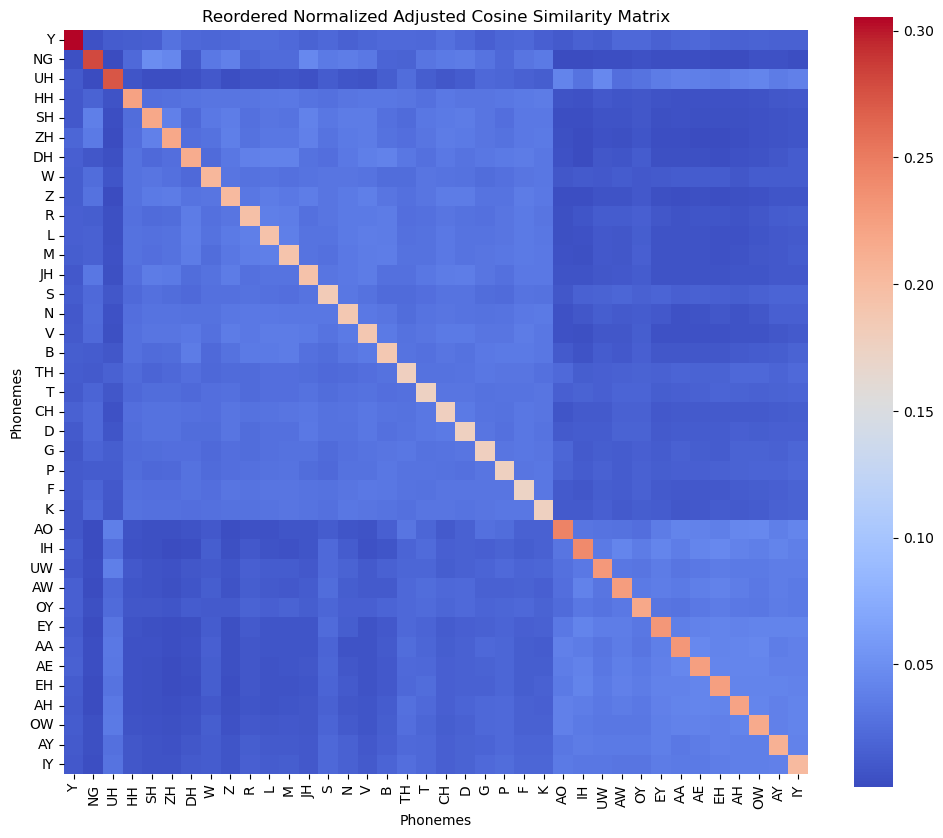

In [13]:
# Let's cluster first

from scipy.cluster.hierarchy import linkage, leaves_list
import seaborn as sns

# Perform hierarchical clustering
link = linkage(normalized_cosine_sim_df, method='average')

# Get the order of rows according to the hierarchy
row_order = leaves_list(link)

# Reorder the DataFrame
sorted_unique_phonemes = np.array(sorted_unique_phonemes)  # Assuming it's a list; convert to NumPy array
sorted_unique_phonemes = sorted_unique_phonemes[row_order]

# Reorder rows and columns based on hierarchical clustering
reordered_df = normalized_cosine_sim_df.loc[sorted_unique_phonemes, sorted_unique_phonemes]

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(reordered_df, annot=False, cmap='coolwarm', cbar=True, square=True)
plt.title("Reordered Normalized Adjusted Cosine Similarity Matrix")
plt.xlabel("Phonemes")
plt.ylabel("Phonemes")
plt.show()


Much better! we can now see consonants and vowels tend to be grouped together. However, there's a big gap between identity (.2-.3) and high cosine values (which we scaled down to less than 0.05). This means we are not using the color scale completely. Let's leave out the high values and see if we can improve the heatmap. 

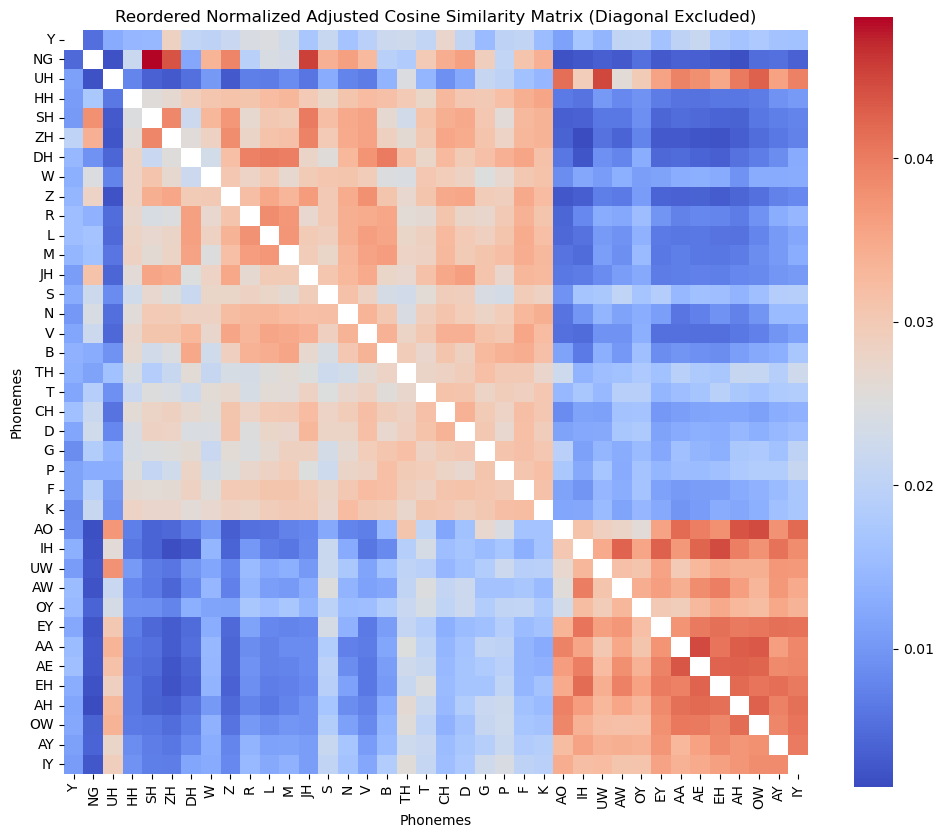

In [14]:
# Let's leave the identity positions out to make the scale smaller

# Set the diagonal entries to NaN
np.fill_diagonal(reordered_df.values, np.nan)
# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(reordered_df, annot=False, cmap='coolwarm', cbar=True, square=True, mask=np.isnan(reordered_df))
plt.title("Reordered Normalized Adjusted Cosine Similarity Matrix (Diagonal Excluded)")
plt.xlabel("Phonemes")
plt.ylabel("Phonemes")
plt.show()


Much better again; now we can really see the structure (unfortunately, UH is getting grouped between NG and HH rather than after K...). It may be that this is not a good basis for estimating human perceptual similarity, but it seems to get the basics correct. 

---



### Bayesian word recogntion simulation

We are now ready to try to simulate words using Bayesian principles. 

The function(s) below carry out calculations according to the principles we reviewed at the start of this notebook. 

Note the `topX` variable. Norris and McQueen say it is fine to compute posteriors over the whole lexicon, because most words will have low evidence, and they limit to the top 50 words simply for convenience. However, when you have 17,000 words and all have non-zero evidence, even miniscule evidence 17,000 times adds up to a lot. So the `topX` value actually matters a lot. If we don't make this a pretty small number (like 50 relative to 17,000) our probabilities will be tiny... 

In [15]:

import time
from collections import defaultdict
import pandas as pd
import numpy as np

def get_phoneme_prob_at_position(phoneme, normalized_cosine_sim_df, phoneme_prob_dict):
    
    """
    Calculate the bottom-up probability for a phoneme at a given position.
    
    Parameters:
        phoneme (str): The current phoneme.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing the normalized cosine similarities between phonemes.
        phoneme_prob_dict (dict): The dictionary containing the probabilities of each phoneme.
        
    Returns:
        pd.Series: The probabilities of each phoneme at the current position.
    """
    evidence_distribution = normalized_cosine_sim_df.loc[phoneme]
    
    # Instead of multiplying the whole Series with a dictionary, use map for element-wise multiplication
    evidence_distribution = evidence_distribution.map(lambda x: x * phoneme_prob_dict.get(x, 1))

    # normalize (back to probabilities) and return
    return evidence_distribution / evidence_distribution.sum()

def sim_bayes_new(target_word, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX=50):
    """
    Simulate word recognition based on Bayesian inference.
    
    Parameters:
        target_word (str): The target word to recognize.
        lexicon_df (DataFrame): The DataFrame containing the lexicon.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing the normalized cosine similarities between phonemes.
        phoneme_prob_dict (dict): The dictionary containing the probabilities of each phoneme.
        topX: how many words to retain in the dictionary based on peak evidence values
        
    Returns:
        posterior_word_df, posterior_phon_df: 2 dataframes with word and phoneme probabilities by position
    """
    # Initialize
    start_time = time.time()
    print(f'--- Starting simulation of word {target_word}', end = "")
    # let's get the phonemes for the target word
    # this just pulls the Pronunciation for the target word
    target_pronunciation = lexicon_df.loc[lexicon_df['Item'] == target_word, 'Pronunciation'].values[0]
    target_phonemes = target_pronunciation.split()
    result_list = []
    phoneme_prob_list = []  # New list to store phoneme probabilities

    # Print the elapsed time -- nothing essential, just updating the user
    # part1 = time.time()
    # elapsed_time = part1 - start_time
    # print(f"  Part 1a: {elapsed_time:.6f} seconds")
    
    # this is wasteful to compute every time, but it takes very little time
    # we need the sum of all lfrq values to convert to probabilities
    total_frequency = lexicon_df['lfrq'].sum()
    
    # now we divide the lfrq values by total_frequency
    # we go ahead and do it in word_prob_dict because it has local scope -- we 
    # are not changing the lexicon outside the function, just the 'copy' we have
    # inside the function (could make a version of this outside the function and
    # pass it inside and then skip this normalization step...)
    word_prob_dict = {row['Item']: row['lfrq'] / total_frequency for index, row in lexicon_df.iterrows()}

    # Print the elapsed time -- just keeping user updated, and trying to figure
    # out how long each part is taking
    # part2 = time.time()
    # elapsed_time = part2 - part1
    # print(f"  Part 1b: {elapsed_time:.6f} seconds")

    # Print the elapsed time from start_time so far
    # elapsed_time = time.time() - start_time
    # print(f"  Times so far: {elapsed_time:.6f} seconds")

    # Loop through each phoneme in the target word
    for phoneme_pos, phoneme in enumerate(target_phonemes, 1):
        phon_start = time.time()

        # Step 1: Get the bottom-up probability for the phoneme
        phoneme_prob_at_pos = get_phoneme_prob_at_position(phoneme, normalized_cosine_sim_df, phoneme_prob_dict)
        
        # Store the phoneme probabilities in the new list
        for p, prob in phoneme_prob_at_pos.items():
            phoneme_prob_list.append({'Phoneme Position': phoneme_pos, 'Phoneme': p, 'Probability': prob})
            # for debugging / inspection -- uncomment next line to see the phoneme probabilities at 
            # each phoneme_pos
            #print(f'     ##### Phoneme Position {phoneme_pos}, Phoneme {p}, Probability {prob}')

        # Step 2: Calculate the probability of each word's substrings (pseq)
        updated_prob_dict = defaultdict(float)
        for word, word_pronunciation in lexicon_df[['Item', 'Pronunciation']].values:
            word_phonemes = word_pronunciation.split()
            
            # this is brute force way to deal with words that are shorter than 
            # the current word -- we just ignore them once the input is longer 
            # than their length... Maybe this is not the best idea? To look at
            # later... 
            if len(word_phonemes) < phoneme_pos:
                continue
            
            # now we want pseq to be the product of the phoneme probabilities 
            # for the current word at each position. We set it to 1.0 initially
            # so we can multiply it by the probabilities... This is the likelihood
            # step: 𝐿𝑖𝑘𝑒𝑙𝑖ℎ𝑜𝑜𝑑(𝑊𝑜𝑟𝑑𝑖)=𝑃(𝐸𝑣𝑖𝑑𝑒𝑛𝑐𝑒|𝑊𝑜𝑟𝑑𝑖)=𝑃(𝑃ℎ𝑜𝑛𝑒𝑚𝑒𝑆𝑡𝑟𝑖𝑛𝑔𝑖)=∏𝑗=1𝑙𝑃(𝑃ℎ𝑜𝑛𝑒𝑚𝑒𝑗|𝐸𝑣𝑖𝑑𝑒𝑛𝑐𝑒)
            pseq = 1.0
            for i in range(phoneme_pos):
                pseq *= phoneme_prob_at_pos.get(word_phonemes[i], 0)
                
            # Step 3: Multiply by word probability and update
            # We take the pseq product and multiply by the word's probability
            # this is the step of 𝑃(𝐸𝑣𝑖𝑑𝑒𝑛𝑐𝑒|𝑊𝑜𝑟𝑑𝑖)×𝑃(𝑊𝑜𝑟𝑑𝑖) for 𝑊𝑜𝑟𝑑𝑖
            updated_prob_dict[word] = pseq * word_prob_dict[word]
        
        # Diagnostic prints for phoneme position 1
        # if phoneme_pos == 1:
        prob_values = list(updated_prob_dict.values())
        # print(f"Statistics before normalization at phoneme {phoneme_pos}:")
        # print(f"  Max: {max(prob_values):.15f}")
        # print(f"  Min: {min(prob_values):.15f}")
        # print(f"  Mean: {sum(prob_values) / len(prob_values):.15f}")
        # print(f"  Std: {sum((x - sum(prob_values) / len(prob_values))**2 for x in prob_values)**0.5 / len(prob_values):.15f}")

        # Sort by probability and take only top X words
        sorted_words = sorted(updated_prob_dict.items(), key=lambda x: x[1], reverse=True)[:topX]
        # Always include the target_word
        if target_word not in [word for word, _ in sorted_words]:
            sorted_words.append((target_word, updated_prob_dict.get(target_word, 0)))

        total_prob = sum([prob for word, prob in sorted_words])
        
        # Normalize only top X words
        updated_prob_dict = {word: prob / total_prob for word, prob in sorted_words}

        # Update lexicon to only include these top X words for the next phoneme
        lexicon_df = lexicon_df[lexicon_df['Item'].isin([word for word, prob in sorted_words])]
        
        # Normalize the updated probabilities
        total_prob = sum(updated_prob_dict.values())
        for word in updated_prob_dict:
            updated_prob_dict[word] /= total_prob
        
        # Diagnostic prints for phoneme position 1
        # if phoneme_pos == 1:
        # prob_values = list(updated_prob_dict.values())
        # print(f"Statistics POST normalization at phoneme {phoneme_pos}:")
        # print(f"  Max: {max(prob_values):.15f}")
        # print(f"  Min: {min(prob_values):.15f}")
        # print(f"  Mean: {sum(prob_values) / len(prob_values):.15f}")
        # print(f"  Std: {sum((x - sum(prob_values) / len(prob_values))**2 for x in prob_values)**0.5 / len(prob_values):.15f}")

        # Update word_prob_dict for next iteration
        word_prob_dict = updated_prob_dict
        
        # Create a DataFrame for this phoneme position and append to the result list
        temp_df = pd.DataFrame(list(word_prob_dict.items()), columns=['Item', 'Probability'])
        temp_df = temp_df.sort_values(by='Probability', ascending=False)
        temp_df['Phoneme Position'] = phoneme_pos
        result_list.append(temp_df)
        
        # Print the elapsed time for this phoneme
        # elapsed_time = time.time() - phon_start
        # print(f"      Time elapsed after processing phoneme {phoneme_pos}: {elapsed_time:.6f} seconds")        
        
    # New DataFrame for phoneme probabilities
    posterior_phon_df = pd.DataFrame(phoneme_prob_list)
    
    # Combine all the DataFrames into one and return 
    # [ignore_index=True speeds things by disregarding existing index values]
    result_df = pd.concat(result_list, ignore_index=True)

    # Calculate peak activations for each word
    peak_activations = result_df.groupby('Item')['Probability'].max().sort_values(ascending=False).reset_index()
    
    # Select the target topX words by peak activation
    top_words = peak_activations.head(topX)
    
    # Filter final results to only include these top words
    posterior_word_df = result_df[result_df['Item'].isin(top_words['Item'])]
    
    # Create an ordered list of words based on peak activations
    sorted_words_by_peak = top_words['Item'].tolist()

    # Move the target word to the top of the list
    sorted_words_by_peak.remove(target_word)
    sorted_words_by_peak = [target_word] + sorted_words_by_peak
    
    # Create a dictionary to map each word to its index in sorted_words_by_peak, formatted as a string
    sort_order = {word: f"{index:02d}" for index, word in enumerate(sorted_words_by_peak)}
    
    # Add a new column that indicates the sort order based on peak activations
    posterior_word_df = posterior_word_df.copy()
    posterior_word_df['ItemWithOrder'] = posterior_word_df['Item'].apply(lambda x: f"{sort_order.get(x, '99')}-{x}")
    
    # Add a target_word column to the final result DataFrames; could help with subsequent analysis
    posterior_word_df['Target Word'] = target_word
    posterior_phon_df['Target Word'] = target_word
     
    # Print the total elapsed time
    total_elapsed_time = time.time() - start_time
    print(f"\t... Time for simulation: {total_elapsed_time:.6f} seconds")
    
    return posterior_word_df, posterior_phon_df  # Return both DataFrames

# Uncomment the following lines to test the function once you have all the required DataFrames and dictionaries.
word_result, phon_result = sim_bayes_new('cat', lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict)



--- Starting simulation of word cat	... Time for simulation: 0.319342 seconds


Okay, we have simulated one word! How can we visualize the results? Let's make a function that will generate a plot from the kind of result we get from our simulation function. 

In [23]:
import itertools

def plot_simulation_result(word_result, phon_result, log_scale=False, full_scale=False,
                           saveplots=False, phonplot=12, wordplot=20):
    """
    Plots a line graph based on the simulation result DataFrame and phoneme probabilities.
    
    Parameters:
        word_result (DataFrame): The DataFrame containing simulation results.
        phon_result (DataFrame): The DataFrame containing phoneme probabilities.
        log_scale (bool): Whether to use a log scale for the Y-axis. Default is False.
    """
    
    unique_words = word_result['Target Word'].unique()
    
    for word in unique_words:
        # Filter data for the current word
        word_data = word_result[word_result['Target Word'] == word]
        phon_data = phon_result[phon_result['Target Word'] == word]
        
        marker_list = [".","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
        marker_iter = itertools.cycle(marker_list)
        
        fig, axs = plt.subplots(1, 2, figsize=(18, 8))
        
        # Initialize empty lists for legend labels and handles
        word_legend_labels = []
        word_legend_handles = []
        
        # First subplot for word probabilities
        for name, group in word_data.groupby('ItemWithOrder'):
            marker = next(marker_iter)
            line, = axs[0].plot(group['Phoneme Position'], group['Probability'], marker=marker, markersize=6)
            word_legend_labels.append(name)
            word_legend_handles.append(line)
        
        # the wordplot arguments limit the lists to that many items in the legend, even if more lines plot
        axs[0].legend(word_legend_handles[:wordplot], word_legend_labels[:wordplot])
        axs[0].set_xlabel('Phoneme Position')
        axs[0].set_ylabel('Probability')
        axs[0].set_title(f'Word probabilities for {word}')
        axs[0].set_xticks(np.arange(min(word_data['Phoneme Position']), max(word_data['Phoneme Position']) + 1, 1.0))
        
        # Calculate peak activations for each phoneme
        peak_phoneme_activations = phon_data.groupby('Phoneme')['Probability'].max().sort_values(ascending=False).reset_index()
        
        # Select the topphon phonemes by peak activation
        top_phonemes = peak_phoneme_activations.head(phonplot)['Phoneme'].tolist()
        #print(top_phonemes)
        
        # Initialize empty lists for legend labels and handles
        phoneme_legend_labels = []
        phoneme_legend_handles = []
        
        # Second subplot for phoneme probabilities
        for name, group in phon_data.groupby('Phoneme'):
            marker = next(marker_iter)
            line, = axs[1].plot(group['Phoneme Position'], group['Probability'], marker=marker, markersize=6)
            # Only add to the legend if the phoneme is among the topphon
            if name in top_phonemes:
                phoneme_legend_labels.append(name)
                phoneme_legend_handles.append(line)        
                
        axs[1].legend(phoneme_legend_handles[:phonplot], phoneme_legend_labels[:phonplot], title='Phonemes')
        axs[1].set_xlabel('Phoneme Position')
        axs[1].set_ylabel('Probability')
        axs[1].set_title(f'Phoneme Probabilities for {word}')
        axs[1].set_xticks(np.arange(min(phon_data['Phoneme Position']), max(phon_data['Phoneme Position']) + 1, 1.0))
        
        if log_scale:
            axs[0].set_yscale('log')
            axs[1].set_yscale('log')
        
        plt.tight_layout()
        
        # If full_scale is True, set the y-axis to range from 0 to 1
        if full_scale:
            axs[0].set_ylim([0, 1])
            axs[1].set_ylim([0, 1])
        
        if saveplots:
            # Ensure the directory exists
            if not os.path.exists('plots'):
                os.makedirs('plots')
            plt.savefig(f'plots/{word}.png')
        
        plt.show()

# Test the function
#plot_simulation_result(word_result, phon_result)


Now let's make a function that will let us simulate many words. 

In [24]:
import pandas as pd

def run_simulations(word_list, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX=50):
    """
    Runs simulations for a list of words and returns aggregated results.
    
    Parameters:
        word_list (list): List of words to simulate.
        lexicon_df (DataFrame): The DataFrame containing the lexicon.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing normalized cosine similarities.
        phoneme_prob_dict (dict): Dictionary containing the probabilities of each phoneme.
        topX (int): Number of top words to consider during simulation. Default is 50.
    
    Returns:
        DataFrame, DataFrame: Aggregated word and phoneme results.
    """
    
    # Initialize empty DataFrames to store aggregated results
    aggregated_word_results = pd.DataFrame()
    aggregated_phoneme_results = pd.DataFrame()
    
    for word in word_list:
        #print(f"--- Running simulation for word: {word}")
        word_result, phon_result = sim_bayes_new(word, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX)
        
        # Append the results to the aggregated DataFrames
        aggregated_word_results = pd.concat([aggregated_word_results, word_result], ignore_index=True)
        aggregated_phoneme_results = pd.concat([aggregated_phoneme_results, phon_result], ignore_index=True)
    
    return aggregated_word_results, aggregated_phoneme_results

--- Starting simulation of word cat	... Time for simulation: 0.337563 seconds
--- Starting simulation of word dog	... Time for simulation: 0.305721 seconds
--- Starting simulation of word abrupt	... Time for simulation: 0.301995 seconds
--- Starting simulation of word territory	... Time for simulation: 0.308805 seconds
--- Starting simulation of word abandon	... Time for simulation: 0.311380 seconds
--- Starting simulation of word clamp	... Time for simulation: 0.308580 seconds
--- Starting simulation of word intolerable	... Time for simulation: 0.313413 seconds
--- Starting simulation of word sew	... Time for simulation: 0.314473 seconds


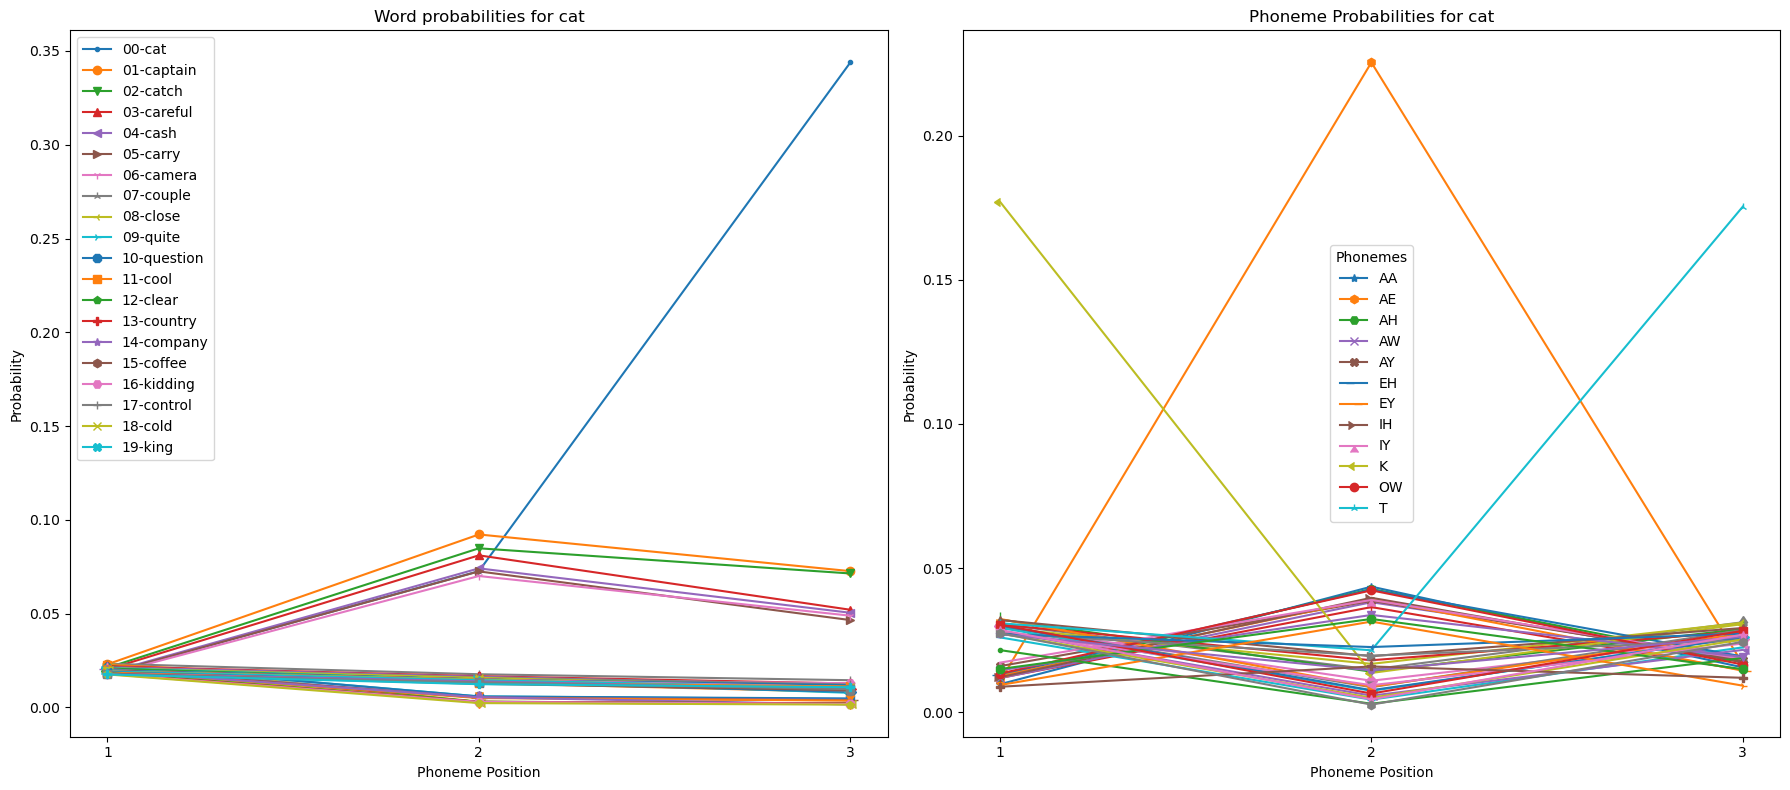

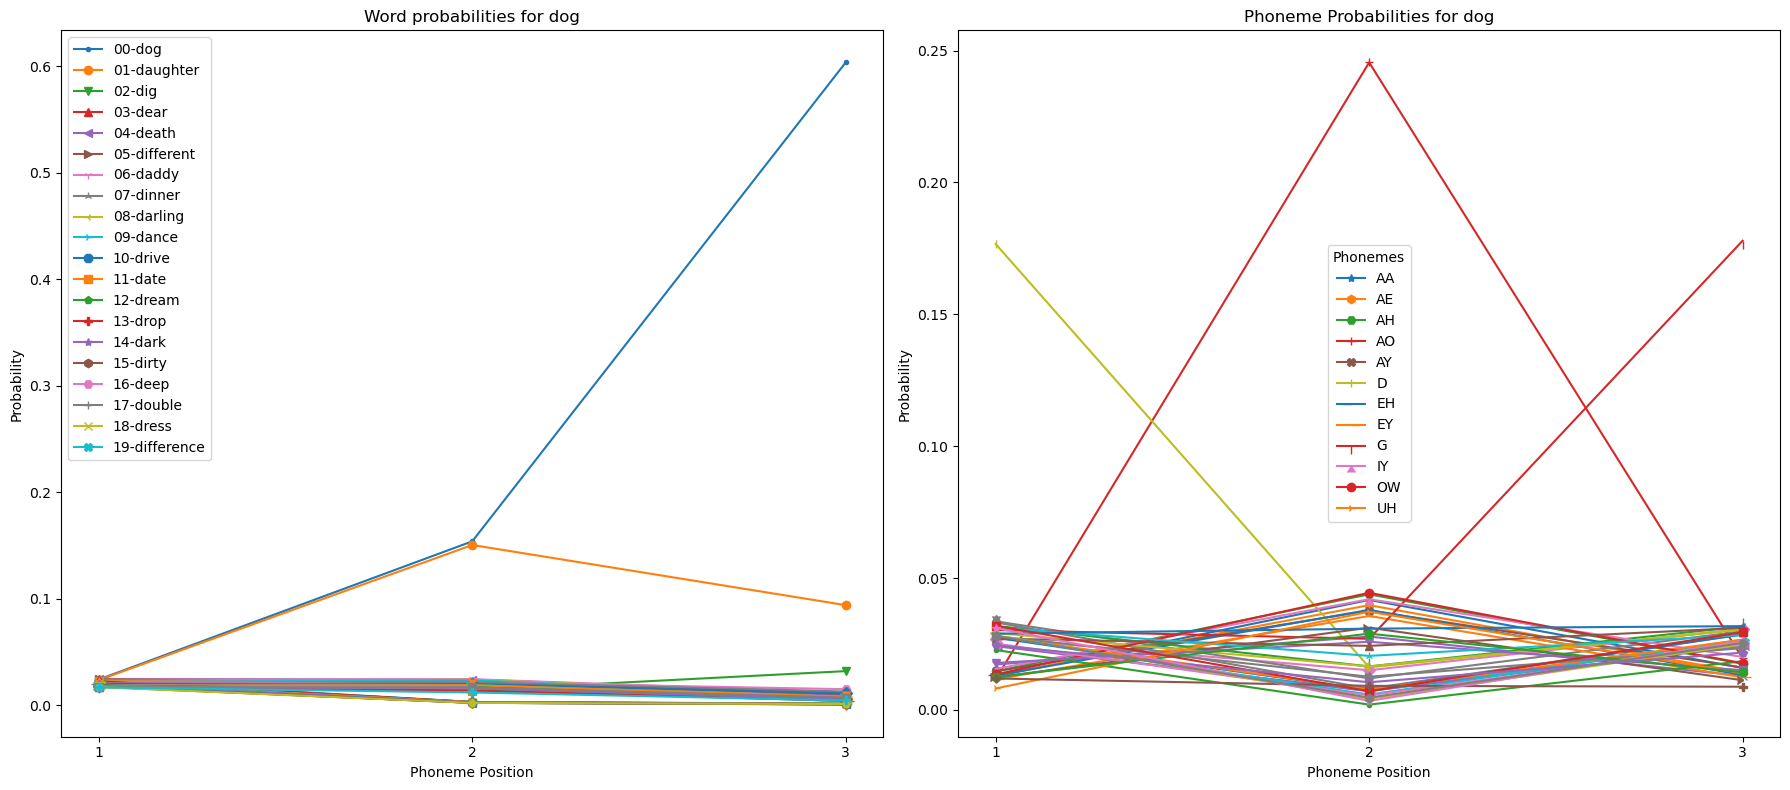

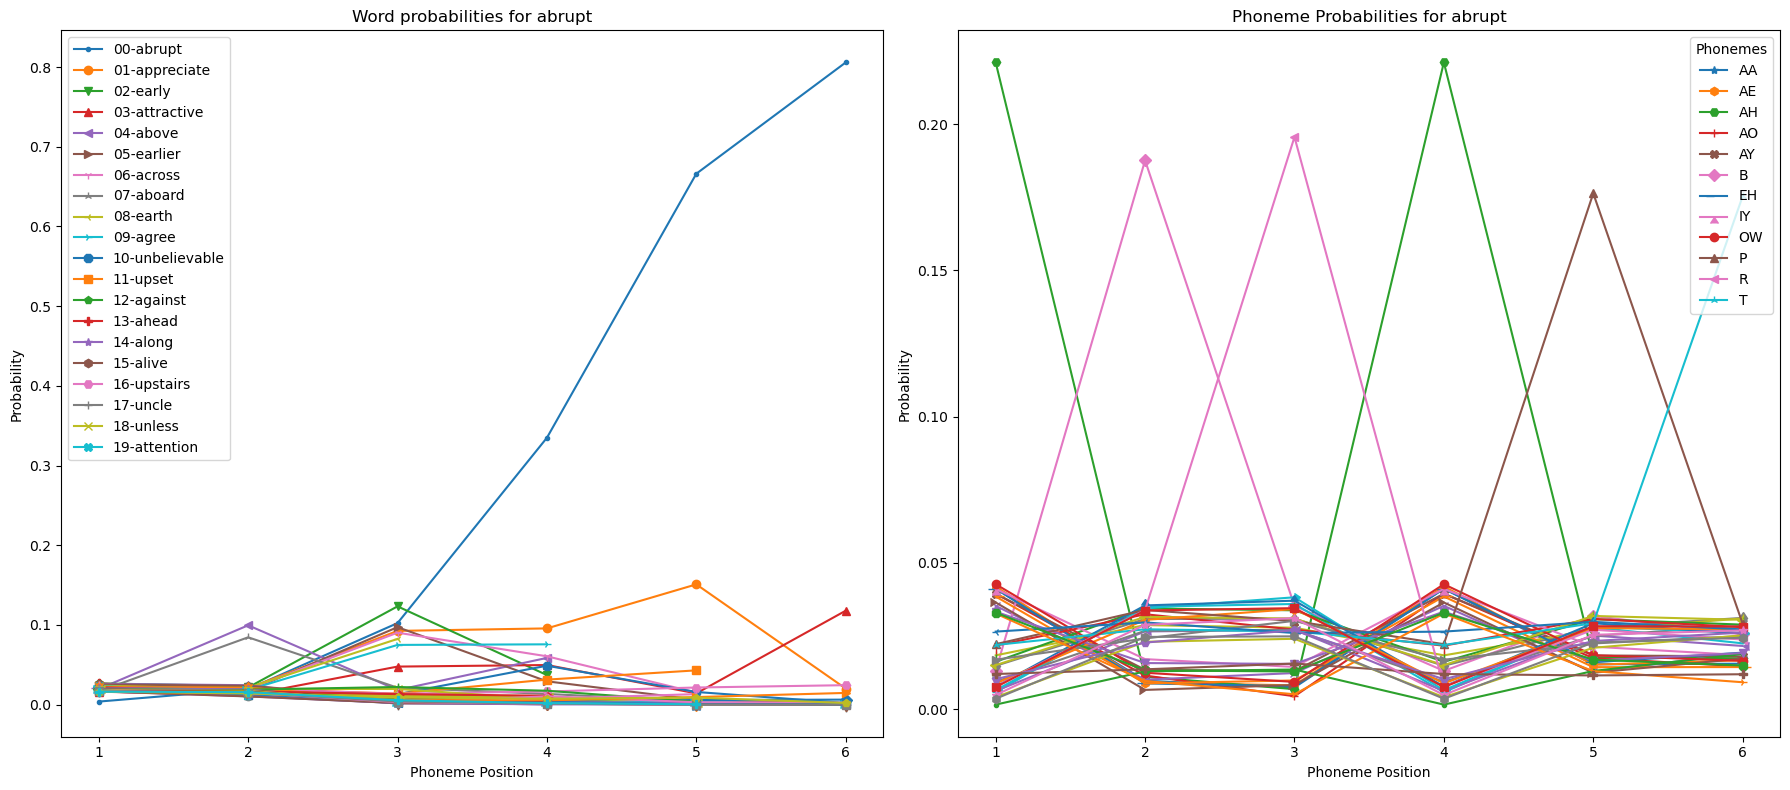

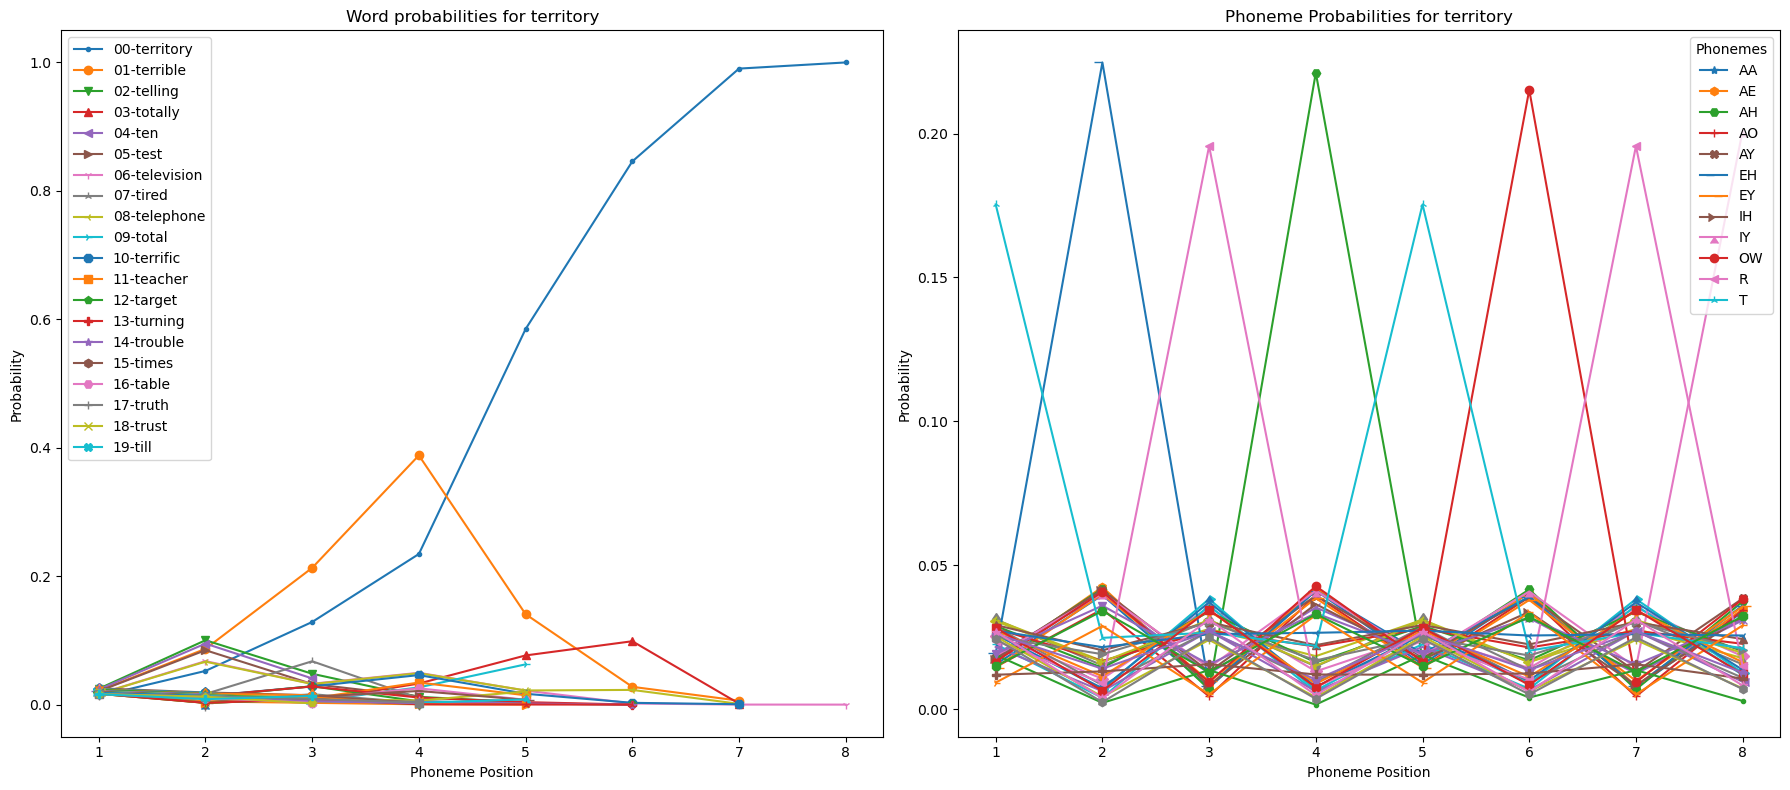

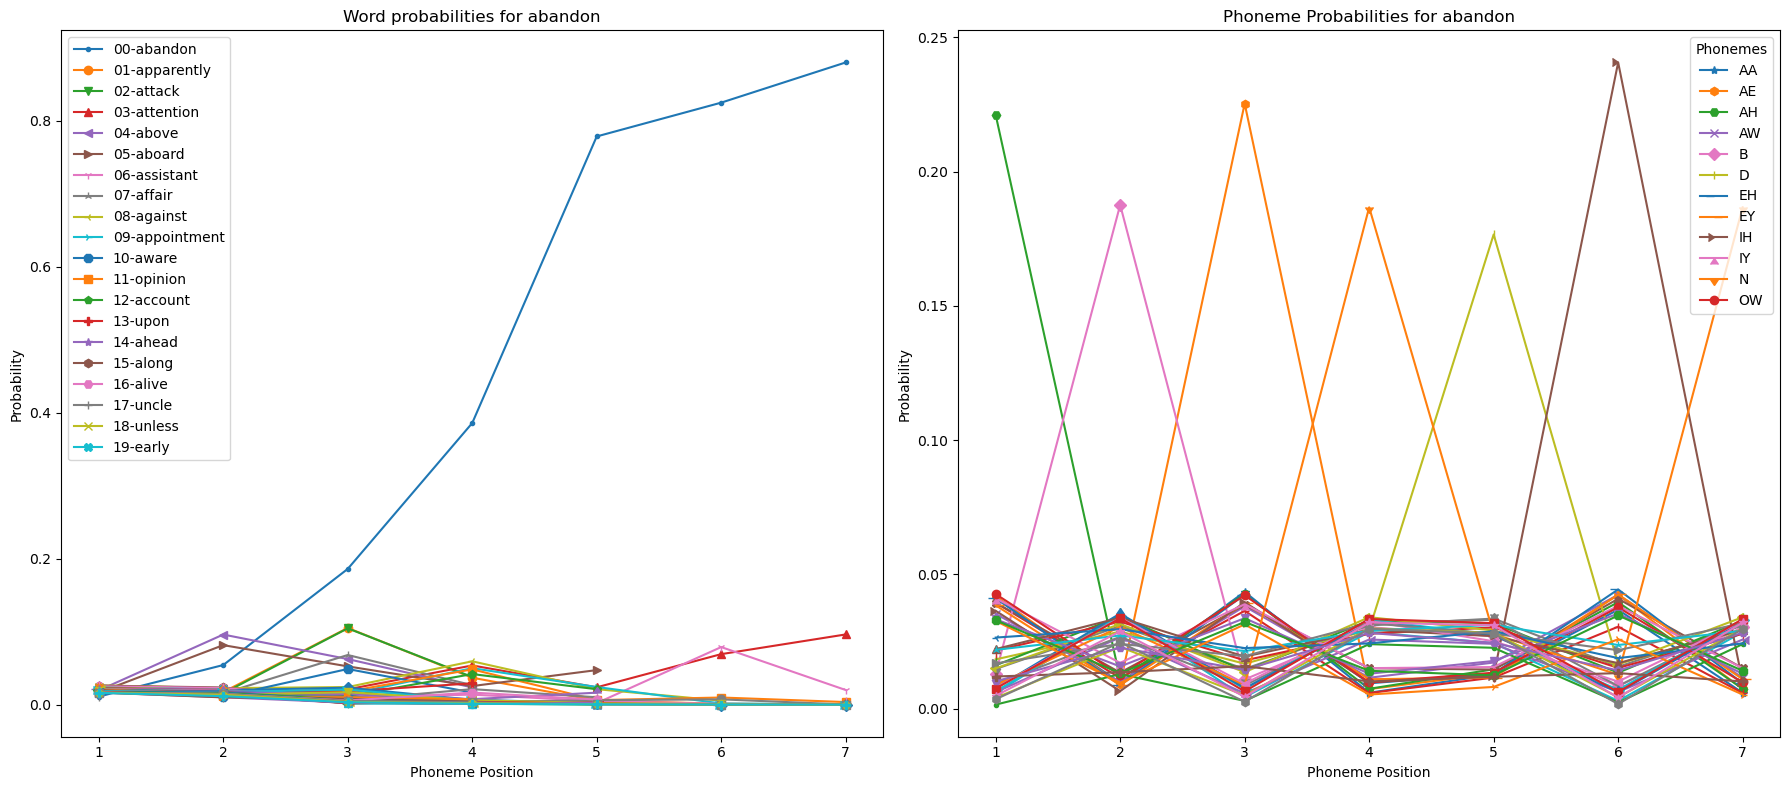

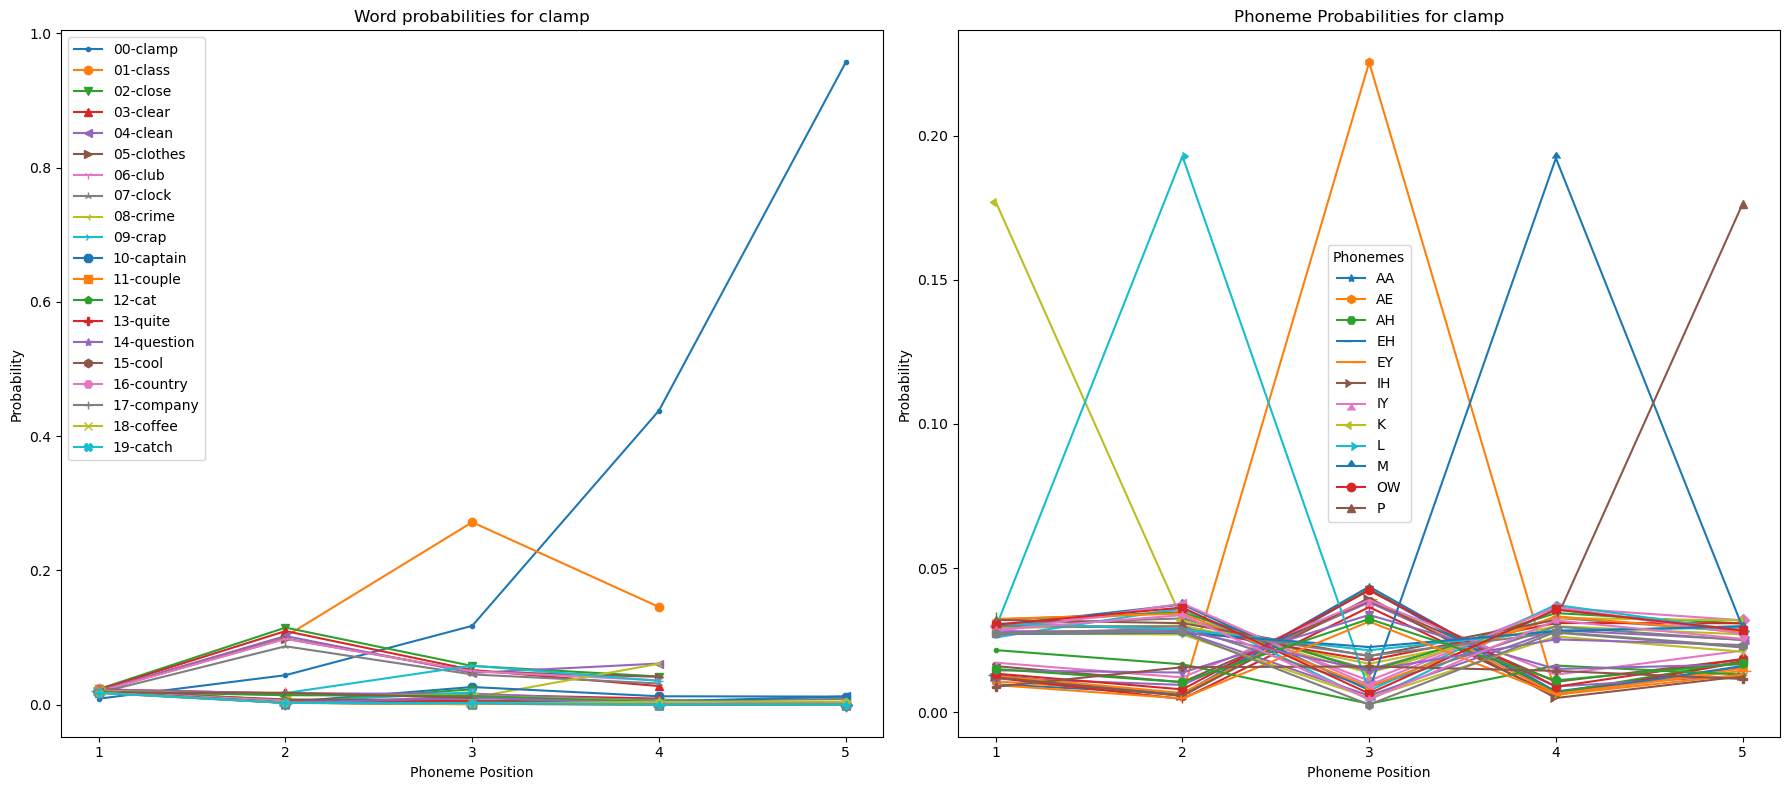

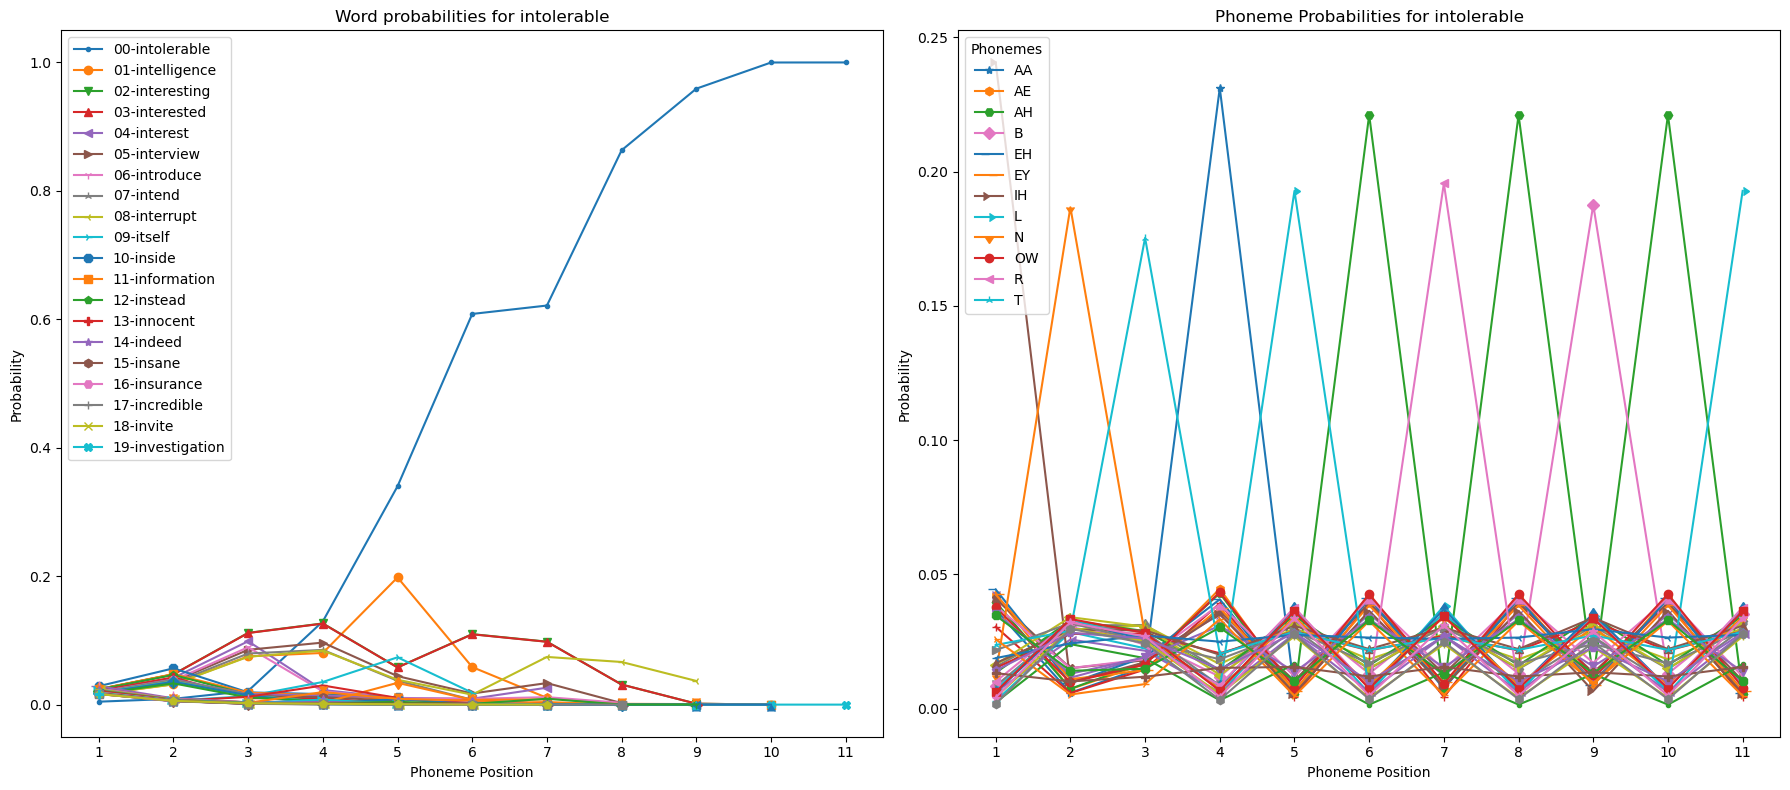

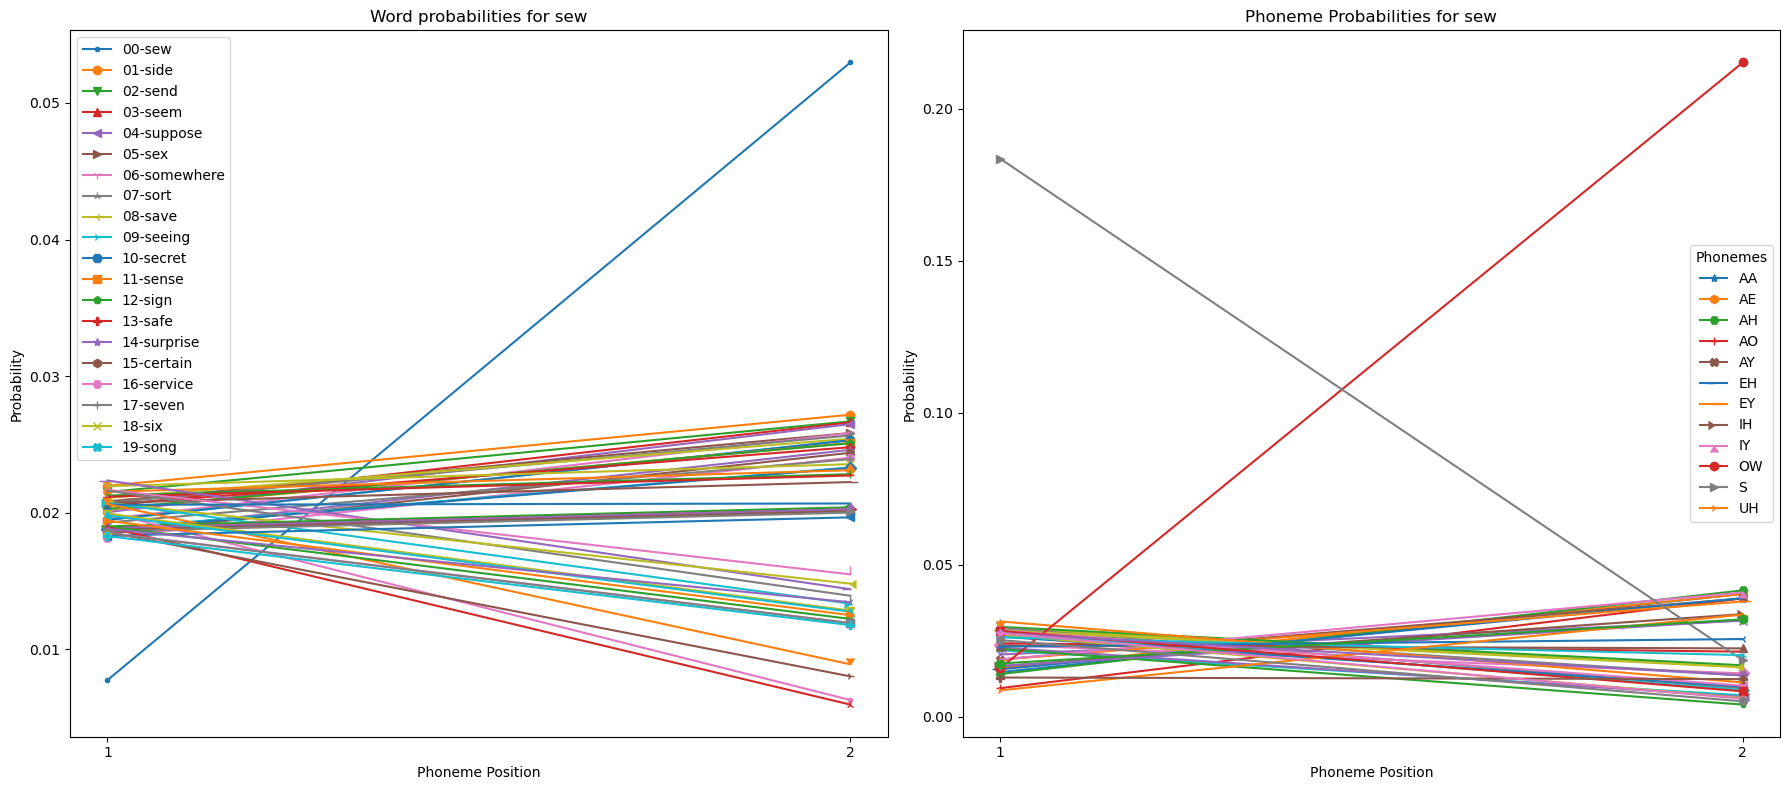

In [25]:
# Example usage:
word_list = ['cat', 'dog', 'abrupt', 'territory', 'abandon', 'clamp', 'intolerable', 'sew']
aggregated_word_results, aggregated_phoneme_results = run_simulations(word_list, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict)
plot_simulation_result(aggregated_word_results, aggregated_phoneme_results)

# Lab report

1. Write a brief summary of the Bayesian approach we are using here (3-4 sentences).

2. Examine the plots above. What observations can you make? Does it seem the system works well? 

3. Replot, but set `full_scale=True`, which will make the Y axes go from 0 to 1 (see code below, which you can enter in a new code cell). Now review the new plots. What kinds of changes do you see? Are there any things that seem problematic?

```python
plot_simulation_result(aggregated_word_results, aggregated_phoneme_results, full_scale=True)
```

4. What are some other words you think might be interesting to examine? Run new simulations with your words. Replace the word list below with the words you want to examine and copy the 3 lines of code into a new code cell. Run it. Include the code lines in your report. Explain why you chose the words you did, and report some observations about the results.

```python
# change the words in word list; you can make the list longer or shorter. Try at least 4 words.
word_list = ['cat', 'dog', 'abrupt', 'territory', 'abandon', 'clamp', 'intolerable', 'go']
aggregated_word_results, aggregated_phoneme_results = run_simulations(word_list, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict)
plot_simulation_result(aggregated_word_results, aggregated_phoneme_results, full_scale=True)
```
5. How could we decide if a simulation should be considered successful or not? That is, how can we assess whether the word has been correctly recognized? 

6. Do you see any problems with the results so far? List them again, but also try to pair them with a possible solution -- something you could change in the simulations that would improve results.

#### Challenge questions -- optional

*PhD and honors students: do at least one of these. Everyone else -- you can do them for extra credit.*

7. *Programming challenge.* Write a function that takes a dataframe like `aggregated_word_results` and assesses whether the word was recognized correctly or not, using the approach you came up with for question 5. 

8. *Programming challenge.* Write code (does not have to be a function) that takes a random sample of words from the lemmalex lexicon and then run simulations on that list of words and make plots. Maybe just try getting this to work for 5 words initially. 

9. *Theoretical challenge.* What are some aspects of spoken word recognition that are missing from our current approach? Consider the challenges from the Magnuson & Crinnion review. 